<a href="https://colab.research.google.com/github/kymEwhain/-38428-02-teamproject/blob/main/%EC%95%BC%EA%B5%AC%EC%84%A0%EC%88%98%EC%97%B0%EB%B4%89%EC%83%81%EC%8A%B9%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK : 야구 선수(pitcher)의 한 해 동안의 성과 기록을 바탕으로 다음 해 연봉의 상승/하락(유지)을 예측한다.

# **0. import**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, f1_score, recall_score, classification_report
from imblearn.combine import SMOTEENN
import xgboost as xgb


# 1. **Data Load**

In [3]:
pitcher = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pitcher_data_without_2024.csv')
fielder = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fielder_data_without_2024.csv')

DATA = pd.concat([pitcher, fielder], ignore_index=True)

### 1-1. 데이터 전처리 및 피쳐 엔지니어링

In [4]:
# 팀 이름과 같은 문자열은 학습의 feature로 사용하기 위해 정수로 인코딩한다.
label_encoder = LabelEncoder()
DATA['Team'] = label_encoder.fit_transform(DATA['Team'])
DATA['CurrentTeam'] = label_encoder.fit_transform(DATA['CurrentTeam'])
DATA['Salary'] = pd.to_numeric(DATA['Salary'], errors='coerce')

# 결측값 처리
DATA.replace('-', pd.NA, inplace=True)
numeric_cols = DATA.select_dtypes(include=['number']).columns
DATA[numeric_cols] = DATA[numeric_cols].fillna(DATA[numeric_cols].mean())

### 1-2. 상호작용 변수추가
야구는 선수의 능력을 판가름하는 특징이 여러개이며, 또한 팀의 재정 상태, 계약 기간 등과 같은 외부 요인의 영향을 많이 받아 까다롭다.

따라서 데이터셋의 기본 피쳐들을 활용하여 추가적인 특징으로 사용하기위해 선수들의 연봉, 나이가 팀에서 어떻게 작용하는지에 대한 변수를 추가하였다.

In [5]:
# 상호작용 변수 추가
DATA['TeamTotalSalary'] = DATA.groupby(['Team', 'Year'])['Salary'].transform('sum')
DATA['Team_Salary_Ratio'] = DATA['Salary'] / DATA['TeamTotalSalary']
DATA['Age_WAR_Interaction'] = DATA['Age'] * DATA['WAR']
DATA['Salary_TeamRatio_Interaction'] = DATA['Salary'] * DATA['Team_Salary_Ratio']

# 2. **모델 학습**

데이터의 feature는 총 63개이다.

pitcher와 fielder의 공통된 피쳐 + 서로에게는 없는 각 포지션의 고유 피쳐를 모두 반영하여 모든 포지션에 대한 통합 예측 모델을 만들고자 함

</br>

2번 스텝에서는...

1. 모든 피쳐를 활용해서 일반적인 모델 Logistic Regression 사용해본다.
2. 모든 피쳐를 활용해서 XGBoost 모델을 사용해본다.
- XGBoost 모델은 피쳐가 많은 데이터를 학습할 때 좋은 성능을 낸다고 알려져있음.


In [6]:
# 선수의 이름, Label, NextYearSalary는 학습 피쳐에서 제외한다.
# 선수의 이름 => 인코딩 불가능
# Label, NextYearSalary => 정답 누출의 가능성
features_all = DATA.columns.drop(['Label', 'PlayerName', 'NextYearSalary'])

X = DATA[features_all]
y = DATA['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 클래스 불균형 처리
# 클래스의 분포가 클래스 1이 더 많아서 불균등한 학습을 방지하기 위함임
X_train_res, y_train_res = SMOTEENN(random_state=42).fit_resample(X_train, y_train)

(클래스 분포 살펴보기)


Class Distribution in Training Data:
Label
1    481
0    328
Name: count, dtype: int64
Class Distribution in Test Data:
Label
0    255
1    205
Name: count, dtype: int64


<ipython-input-7-6e33465b2b50>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis')


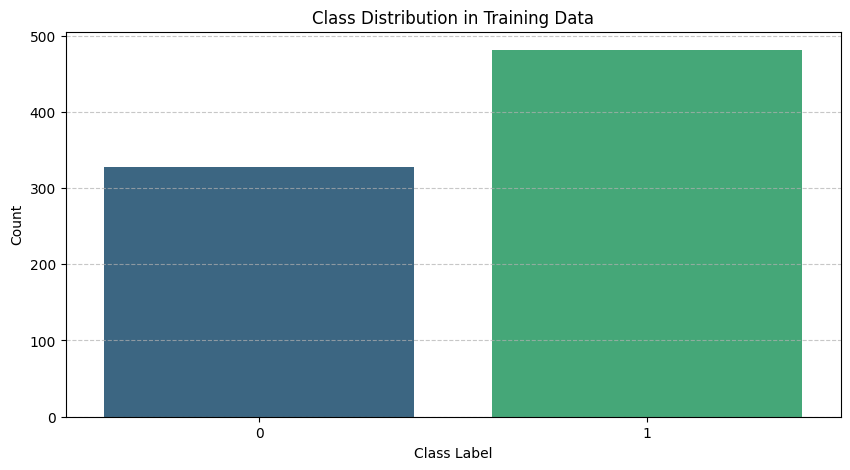

In [7]:
class_counts_train = pd.Series(y_train_res).value_counts()
class_counts_test = pd.Series(y_test).value_counts()
print(f"\nClass Distribution in Training Data:\n{class_counts_train}")
print(f"Class Distribution in Test Data:\n{class_counts_test}")

# 클래스에 따른 데이터 개수 분포 그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2-1. 모든 피쳐를 사용하여 일반 회귀 학습

In [8]:
# Logistic Regression 모델 학습
logistic_model = LogisticRegression()
logistic_model.fit(X_train_res, y_train_res)

# 예측
y_pred_logistic = logistic_model.predict(X_test)

# 평가
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic:.2f}")

Logistic Regression Accuracy: 0.68


### 2-2. 모든 피쳐를 사용하여 XGBoost 모델 학습

In [9]:
# 모든 피쳐를 사용하여 XGBoost 모델 학습
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=8, learning_rate=0.1)
model_xgb.fit(X_train_res, y_train_res)

# 평가
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Model with All Features Accuracy:", accuracy_xgb)

XGBoost Model with All Features Accuracy: 0.7608695652173914


In [10]:
# F1 Score 계산
f1 = f1_score(y_test, y_pred_xgb, average='weighted')  # 평균 방식 선택 가능 ('weighted', 'macro', 'micro')
print(f"F1 Score: {f1:.4f}")

# Recall 계산
recall = recall_score(y_test, y_pred_xgb, average='weighted')
print(f"Recall: {recall:.4f}")

# Classification Report 출력 (전체 메트릭 요약)
report = classification_report(y_test, y_pred_xgb)
print("Classification Report:")
print(report)

F1 Score: 0.7615
Recall: 0.7609
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       255
           1       0.70      0.80      0.75       205

    accuracy                           0.76       460
   macro avg       0.76      0.77      0.76       460
weighted avg       0.77      0.76      0.76       460



# **3. feature 선별하기**

피쳐가 너무 많을 경우, 과적합의 가능성 혹은 아예 데이터의 평균적인 분포를 학습하지 못 할 가능성이 존재한다.

따라서 예측하고자 하는 Label과의 상관관계가 가장 높은 몇 가지의 피쳐를 선별하여 학습을 해본다.

In [31]:
# Feature Importance 기반 중요한 피쳐 선별
print("\n--- Feature Importance 기반 중요한 피쳐 선별 ---")
feature_importances = model_xgb.feature_importances_
important_features = [
    features_all[i] for i in range(len(features_all))
    if feature_importances[i] > np.mean(feature_importances)
    and features_all[i] != "NextYearSalary"  # 제외 조건 추가
    and features_all[i] != "Salary"
]
print("Selected Important Features:", important_features)


--- Feature Importance 기반 중요한 피쳐 선별 ---
Selected Important Features: ['Year', 'Age', 'HD', 'TBF', 'H', 'ERA', 'rRA9', 'WAR', 'TB', 'OBP', 'Team_Salary_Ratio']


In [32]:
X_important = DATA[important_features]

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, y, test_size=0.2, random_state=42, stratify=y)

X_train_imp = scaler.fit_transform(X_train_imp)
X_test_imp = scaler.transform(X_test_imp)

# 클래스 불균형 처리
X_train_imp_res, y_train_imp_res = SMOTEENN(random_state=42).fit_resample(X_train_imp, y_train_imp)

(클래스 분포 살펴보기)

모든 피쳐를 사용했을 때 보다 몇 개의 피쳐를 사용했을 때 클래스의 분포가 조금 더 비슷해짐


Class Distribution in Training Data:
Label
1    508
0    454
Name: count, dtype: int64
Class Distribution in Test Data:
Label
0    255
1    205
Name: count, dtype: int64


<ipython-input-33-4d419b0b101e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis')


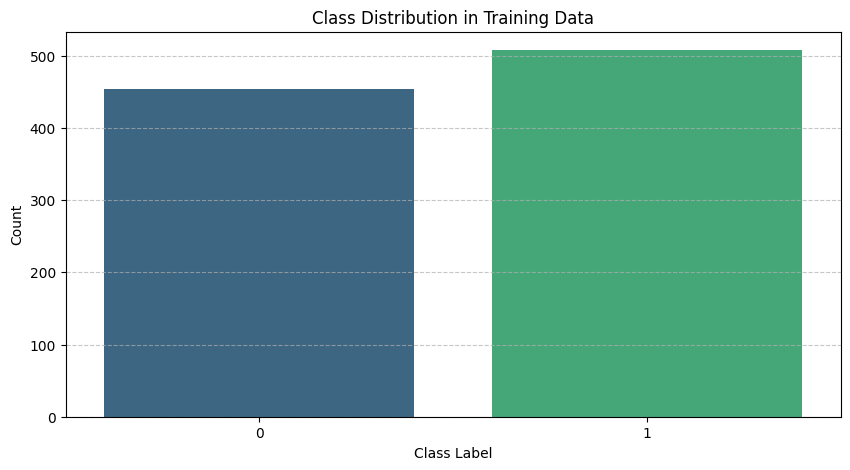

In [33]:
class_counts_train = pd.Series(y_train_imp_res).value_counts()
class_counts_test = pd.Series(y_test_imp).value_counts()
print(f"\nClass Distribution in Training Data:\n{class_counts_train}")
print(f"Class Distribution in Test Data:\n{class_counts_test}")

# 클래스에 따른 데이터 개수 분포 그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **4. 선별한 feature를 사용하여 일반 회귀 모델 재학습**

### 4-1. Logistic Regression  모델 재학습

In [34]:
logistic_model_imp = LogisticRegression()
logistic_model_imp.fit(X_train_imp_res, y_train_imp_res)

# 예측
y_pred_logistic = logistic_model_imp.predict(X_test_imp)

# 평가
accuracy_logistic_imp = accuracy_score(y_test_imp, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic_imp:.2f}")

Logistic Regression Accuracy: 0.68


### 4-2. XGBoost 모델 재학습

In [35]:
model_xgb_imp = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=8, learning_rate=0.05)
model_xgb_imp.fit(X_train_imp_res, y_train_imp_res)

# 평가
y_pred_xgb_imp = model_xgb_imp.predict(X_test_imp)
accuracy_xgb_imp = accuracy_score(y_test_imp, y_pred_xgb_imp)
print("XGBoost Model with Important Features Accuracy:", accuracy_xgb_imp)

XGBoost Model with Important Features Accuracy: 0.7521739130434782


In [36]:
# F1 Score 계산
f1 = f1_score(y_test_imp, y_pred_xgb_imp, average='weighted')  # 평균 방식 선택 가능 ('weighted', 'macro', 'micro')
print(f"F1 Score: {f1:.4f}")

# Recall 계산
recall = recall_score(y_test_imp, y_pred_xgb_imp, average='weighted')
print(f"Recall: {recall:.4f}")

# Classification Report 출력 (전체 메트릭 요약)
report = classification_report(y_test_imp, y_pred_xgb_imp)
print("Classification Report:")
print(report)


F1 Score: 0.7528
Recall: 0.7522
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       255
           1       0.69      0.81      0.74       205

    accuracy                           0.75       460
   macro avg       0.76      0.76      0.75       460
weighted avg       0.76      0.75      0.75       460



# **5. 결과 요약**

In [37]:
# 결과 요약
print("\n--- 성능 요약 ---")
print(f"Linear Regression with All Features MSE: {accuracy_logistic:.2f}")
print(f"XGBoost Model with All Features Accuracy: {accuracy_xgb:.2f}")
print(f"Linear Regression with Important Features MSE: {accuracy_logistic_imp:.2f}")
print(f"XGBoost Model with Important Features Accuracy: {accuracy_xgb_imp:.2f}")


--- 성능 요약 ---
Linear Regression with All Features MSE: 0.68
XGBoost Model with All Features Accuracy: 0.76
Linear Regression with Important Features MSE: 0.68
XGBoost Model with Important Features Accuracy: 0.75


큰 성능 개선은 보이지 않았다.

그 이유를 추론해보면....
1. 야구 선수의 연봉은 능력뿐만 아닌 외부의 요인이 강하게 작용

2. 적은 데이터 개수

3. outlier : 성적은 부진하지만 오랫동안 활동한 선수인 경우, 높은 연봉을 받는 선수들이 간혹 존재

=> 때문에 상승/하락(유지)의 분류의 성능은 나쁘지 않지만, 어느 정도 이상의 성능을 기대하기 어렵다는 것을 알 수 있음

=> 더 나아가, 선수의 연봉을 회귀 방식을 활용하여 예측하는 것은 굉장히 어려울 것임을 알 수 있음

# **6. 성능 확인**

In [24]:
team_salary_sum = DATA.groupby('Team')['Salary'].sum()

def preprocess_and_predict(input_data, team_salary_sum_dict, scaler, model, important_features):
    """
    입력 데이터를 전처리하고 예측값을 반환하는 함수

    Parameters:
    - input_data: dict, 입력 데이터
    - label_encoder: LabelEncoder 객체, 팀 이름을 숫자로 변환
    - team_salary_sum_dict: dict, 팀별 연봉 합 딕셔너리
    - scaler: StandardScaler 객체, 데이터 정규화
    - model: XGBoost 모델 객체, 학습된 모델
    - important_features: list, 모델 학습에 사용된 중요한 피처 리스트

    Returns:
    - y_pred: 예측값
    """
    # 1. Team Encoding
    team_value = input_data['Team']  # 인코딩된 값 그대로 사용
    #input_data['Team'] = label_encoder.transform([input_data['Team']])[0]

    # 2. Salary 변환
    input_data['Salary'] = pd.to_numeric(input_data['Salary'], errors='coerce')

    # 3. Team Total Salary 계산
    if team_value in team_salary_sum_dict:
        team_total_salary = team_salary_sum_dict[team_value]
    else:
        print(f"팀 '{team_value}'에 대한 연봉 데이터가 없습니다.")
        team_total_salary = 1e-9  # 기본값 사용 (0으로 나누기 방지)

    input_data['TeamTotalSalary'] = team_total_salary

    # 4. 추가 Feature 계산
    input_data['Team_Salary_Ratio'] = input_data['Salary'] / input_data['TeamTotalSalary']
    input_data['Age_WAR_Interaction'] = input_data['Age'] * input_data['WAR']
    input_data['Salary_TeamRatio_Interaction'] = input_data['Salary'] * input_data['Team_Salary_Ratio']

    # 5. DataFrame 변환 및 Feature 선택
    input_df = pd.DataFrame([input_data])
    input_df = input_df[important_features]

    # 6. 스케일링 적용
    input_scaled = scaler.transform(input_df)

    # 7. 예측
    y_pred = model.predict(input_scaled)

    return y_pred

In [25]:
input = {
    "Year": 2020,
    "Team": "삼성",
    "Age": 35,
    "Pos.": "P",
    "G": 52,
    "GS": 0,
    "GR": 52,
    "GF": 17,
    "CG": 0,
    "SHO": 0,
    "W": 3,
    "L": 3,
    "S": 7,
    "HD": 11,
    "IP": 48.0,
    "ER": 33,
    "R": 34,
    "rRA": 31.30,
    "TBF": 210,
    "H": 61,
    "2B": 10,
    "3B": 1,
    "HR": 3,
    "BB": 9,
    "HP": 1,
    "IB": 1,
    "SO": 30,
    "ROE": 0,
    "BK": 0,
    "WP": 0,
    "ERA": 6.19,
    "RA9": 6.38,
    "rRA9": 5.87,
    "FIP": 3.76,
    "WHIP": 1.46,
    "WAR": 0.50,
    'Salary': 70000,
    'AB': 0,
    'TB': 0,
    'SLG': 0,
    'OBP': 0
}

input['Team'] = label_encoder.transform([input['Team']])[0]

In [26]:
prdiction = preprocess_and_predict(input, team_salary_sum, scaler, model_xgb_imp, important_features)

print(prdiction)

[0]


=> 실제로 KT의 우규민 선수는 2020년 70,000의 연봉에서 2021년 20,000으로 감소했다.



---



In [27]:
input = {
    "Year": 2023,
    "Team": "삼성",
    "Age": 38,
    "Pos.": "P",
    "G": 56,
    "GS": 0,
    "GR": 56,
    "GF": 4,
    "CG": 0,
    "SHO": 0,
    "W": 3,
    "L": 1,
    "S": 0,
    "HD": 13,
    "IP": 43.0,
    "ER": 23,
    "R": 25,
    "rRA": 25.25,
    "TBF": 188,
    "H": 55,
    "2B": 9,
    "3B": 0,
    "HR": 3,
    "BB": 5,
    "HP": 3,
    "IB": 0,
    "SO": 28,
    "ROE": 1,
    "BK": 0,
    "WP": 0,
    "ERA": 4.81,
    "RA9": 5.23,
    "rRA9": 5.28,
    "FIP": 3.63,
    "WHIP": 1.40,
    "WAR": 0.27,
    'Salary': 25000,
    'AB': 0,
    'TB': 0,
    'SLG': 0,
    'OBP': 0
}

input['Team'] = label_encoder.transform([input['Team']])[0]

In [28]:
prdiction = preprocess_and_predict(input, team_salary_sum, scaler, model_xgb_imp, important_features)

print(prdiction)

[0]


=> 실제로 우규민 선수는 2023년 25,000에서 2024년 22,000으로 감소했다.

In [29]:
input = {
    "Year": 2015,
    "Team": "LG",
    "Age": 30,
    "Pos.": "P",
    "G": 25,
    "GS": 25,
    "GR": 0,
    "GF": 1,
    "CG": 1,
    "SHO": 0,
    "W": 11,
    "L": 9,
    "S": 0,
    "HD": 0,
    "IP": 152.2,
    "ER": 58,
    "R": 64,
    "rRA": 60.10,
    "TBF": 621,
    "H": 163,
    "2B": 26,
    "3B": 5,
    "HR": 13,
    "BB": 17,
    "HP": 12,
    "IB": 0,
    "SO": 119,
    "ROE": 4,
    "BK": 0,
    "WP": 2,
    "ERA": 3.42,
    "RA9": 3.77,
    "rRA9": 3.54,
    "FIP": 3.75,
    "WHIP": 1.18,
    "WAR": 0.21,
    'Salary': 30000,
    'AB': 0,
    'TB': 0,
    'SLG': 0,
    'OBP': 0,
}

input['Team'] = label_encoder.transform([input['Team']])[0]

In [30]:
prediction = preprocess_and_predict(input, team_salary_sum, scaler, model_xgb_imp, important_features)

print(prediction)

[1]


=> 실제 유구민 선수는 2015년에서 30,000에서 2016년 40,000으로 증가했다.

# **7. 2025년도 선수들의 연봉 상승 여부 예측**

In [ ]:
# 새로운 데이터 예측
data_2024_path = '/content/drive/MyDrive/Colab Notebooks/combined_fielder_pitcher_2024_with_label.csv'
data_2024 = pd.read_csv(data_2024_path)

# 데이터 전처리
data_2024.replace('-', pd.NA, inplace=True)
data_2024['Salary'] = pd.to_numeric(data_2024['Salary'], errors='coerce')
numeric_cols = data_2024.select_dtypes(include=['number']).columns
#data_2024[numeric_cols] = data_2024[numeric_cols].fillna(data_2024[numeric_cols].mean())
data_2024.loc[:, numeric_cols] = data_2024[numeric_cols].fillna(0)

# 팀이름 인코딩
data_2024['Team'] = label_encoder.fit_transform(data_2024['Team'])

# 팀별 연봉 합산
team_salary_sum = data_2024.groupby('Team')['Salary'].sum()


# 예측 결과 생성
predictions = []


for _, row in data_2024.iterrows():
    input_data = row.to_dict()  # 각 행을 딕셔너리로 변환
    pred = preprocess_and_predict(input_data, team_salary_sum, scaler, model_xgb_imp, important_features)
    predictions.append(pred[0])  # 예측값 추가

# 예측 결과 저장
data_2024['Predicted_Label'] = predictions
output_path = '/content/drive/MyDrive/Colab Notebooks/pitcher_2025_salary_predictions.csv'
data_2024[['PlayerName', 'Team', 'Year', 'Salary', 'Predicted_Label']].to_csv(output_path, index=False)
print("Predictions for 2024 saved to:", output_path)


Predictions for 2024 saved to: /content/drive/MyDrive/Colab Notebooks/pitcher_2025_salary_predictions.csv
